In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import networkx as nx

color = sns.color_palette()

# 1. Setting Up

In [2]:
# Import necessary libraries

#misc
import gc
import time
import warnings
import json
import os
import ast

import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette()

Load the business dataset

In [3]:
business = pd.read_csv('/home/han2114/final_project_tools_analytics/yelp_academic_dataset_business_full.csv')
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188593 entries, 0 to 188592
Data columns (total 61 columns):
hours.Friday                             141796 non-null object
attributes.RestaurantsAttire             48182 non-null object
attributes.BikeParking                   84891 non-null object
state                                    188593 non-null object
categories                               188052 non-null object
attributes.BusinessParking               103424 non-null object
attributes.Alcohol                       47892 non-null object
attributes.GoodForDancing                9162 non-null object
attributes.BYOB                          911 non-null object
attributes.DietaryRestrictions           138 non-null object
attributes.RestaurantsReservations       51363 non-null object
attributes.GoodForKids                   64931 non-null object
attributes.Smoking                       8113 non-null object
hours.Sunday                             93387 non-null object
attribute

In [4]:
cat_all = ','.join(business['categories'].dropna()).replace(" ", "")
cat_all = pd.DataFrame(cat_all.split(','), columns=['category'])
cat_all_count = cat_all.category.value_counts().sort_values(ascending = False)
print("There are ",len(cat_all_count)," different types/categories of Businesses in Yelp!")

There are  1305  different types/categories of Businesses in Yelp!


In [5]:
cat_all_count[0:10]

Restaurants       57173
Shopping          30231
Food              27118
Beauty&Spas       18967
HomeServices      18634
Health&Medical    16157
LocalServices     12906
Automotive        12656
Nightlife         12438
Bars              10853
Name: category, dtype: int64

In [6]:
tfile = open('cat_all_count.txt', 'a')
tfile.write(cat_all_count.to_string())
tfile.close()

In [7]:
food_masks = ['Restaurants', 'Food','Sandwiches', 'FastFood', 'Breakfast&Brunch', 'SpecialtyFood', 'Burgers',
                    'American(Traditional)', 'American(New)','Pizza', 'Italian','African','Falafel','Turkish',
                    'Desserts', 'Bakeries', 'Salad','ChickenWings', 'Mexican','Seafood','Chinese','Malaysian',
                    'IceCream&FrozenYogurt', 'Delis', 'Japanese', 'Bars', 'Canadian(New)', 'AsianFusion',
                    'Mediterranean', 'SushiBars','JuiceBars&Smoothies','Steakhouses','Coffee&Tea','Pretzels','PanAsian',
                    'Barbeque','Beer','Wine&Spirits','SportsBars', 'Pubs','British','Poke','Delicatessen',
                     'Lounges', 'WineBars', 'CocktailBars', 'Diners','Patisserie/CakeShop','Kosher','Afghan',
                     'Vegetarian', 'EthnicFood', 'MiddleEastern','Persian/Iranian','FoodCourt','IrishPub',
                     'Gluten-Free','ComfortFood','Indian','Soup','Vegan', 'Thai','FoodTrucks','Szechuan',
                     'French','Greek','Buffets','Vietnamese','HotDogs','DiveBars','Tex-Mex','HotPot','Polish','Moroccan',
                     'ImportedFood','Gastropubs','Bagels','BeerBar','Halal','Korean','Donuts','Tapas/SmallPlates',
                     'Breweries','Southern','LatinAmerican','Do-It-YourselfFood','InternetCafes','Cantonese',
                     'BubbleTea','TapasBars','Caribbean','Lebanese','CoffeeRoasteries','Gelato','Brazilian',
                     'Pakistani','FoodStands','Hawaiian','Dim Sum','Tacos','SoulFood','Creperies','Ethiopian',
                     'Fish&Chips','Cajun/Creole','Irish','ShavedIce','InternetCafes','Bistros','Peruvian','Waffles',
                     'ModernEuropean','Taiwanese','Filipino','Cheesesteaks','German','Brasseries','Cuban',
                     'Wineries','Ramen','Spanish','Poutineries','TeaRooms','Noodles','Cupcakes','Portuguese']

In [8]:
bus_cats = business['categories']
index_food_masks = list()
NaN_list = list()
for index, bus_cat in enumerate(bus_cats):
    if pd.isnull(bus_cat) == True:
        NaN_list.append(index)
    else:
        if bool(set(bus_cat.replace(" ","").split(',')) & set(food_masks)):
            index_food_masks.append(index)

In [9]:
restaurants = business.iloc[index_food_masks]

In [10]:
cat_all_res = ','.join(restaurants['categories']).replace(" ", "")
cat_all_res = pd.DataFrame(cat_all_res.split(','), columns=['category'])
cat_all_res_count = cat_all_res.category.value_counts().sort_values(ascending = False)
print("There are ",len(cat_all_res_count)," different types/categories of Restaurants in Yelp!")

There are  835  different types/categories of Restaurants in Yelp!


Choose only US and Canada

In [11]:
USA_mask = ['AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL','IN','IA','KS','KY',
            'LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND',
            'OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY']
CAN_mask = ['ON','QC','AB','BC','MB','NB','NL','NT','NS','NU','PE','SK','YT']
location_mask = USA_mask + CAN_mask

In [12]:
index_location_mask = list()
state = restaurants['state']
for index, state in enumerate(state):
    if state in location_mask:
        index_location_mask.append(index)

In [13]:
restaurants = restaurants.iloc[index_location_mask]

In [14]:
def label_country (row):
    if row['state'] in  USA_mask:
          return 'USA'
    if row['state'] in  CAN_mask:
          return 'Canada'

restaurants['country'] = restaurants.apply(lambda row: label_country(row),axis=1)

# 2. Exploratory Data Analysis

### 2A. Rating Distributions

In [15]:
# Get the distribution of the ratings
rating_dist = restaurants['stars'].value_counts().sort_index()
rating_dist

1.0      537
1.5     1534
2.0     4058
2.5     7386
3.0    12931
3.5    17339
4.0    18063
4.5    10010
5.0     3168
Name: stars, dtype: int64

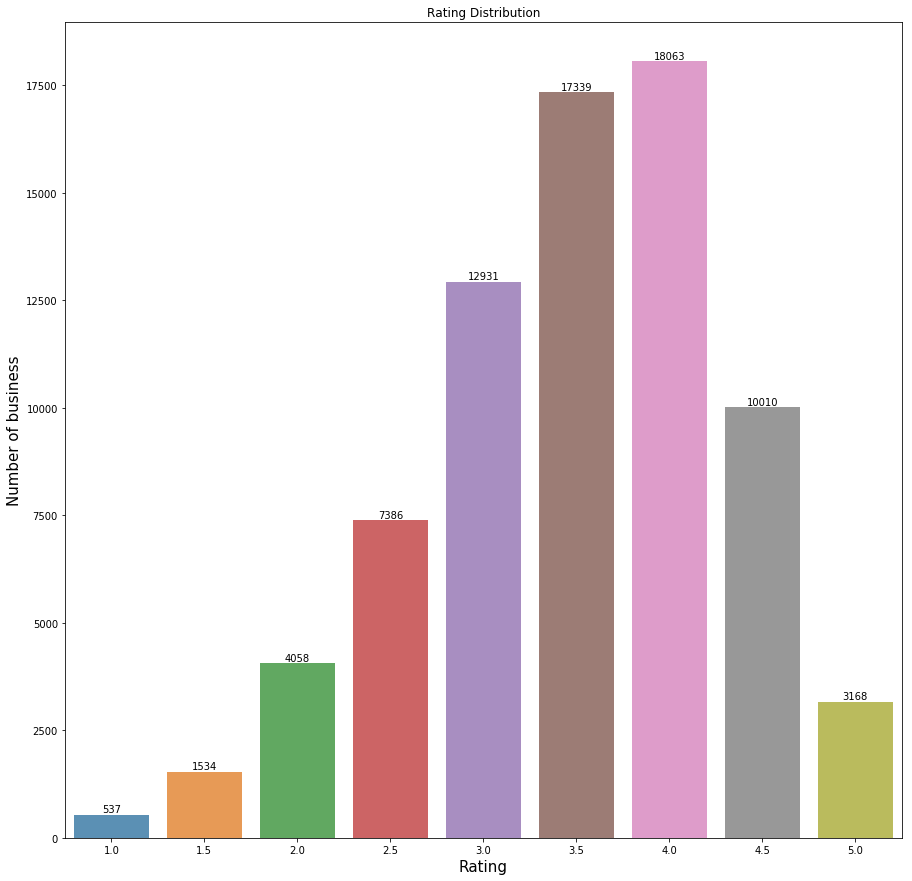

In [16]:
plt.figure(figsize=(15,15))
ax = sns.barplot(rating_dist.index, rating_dist.values, alpha=0.8)
plt.title("Rating Distribution")
plt.ylabel('Number of business', fontsize=15)
plt.xlabel('Rating', fontsize=15)

rects = ax.patches
labels = rating_dist.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

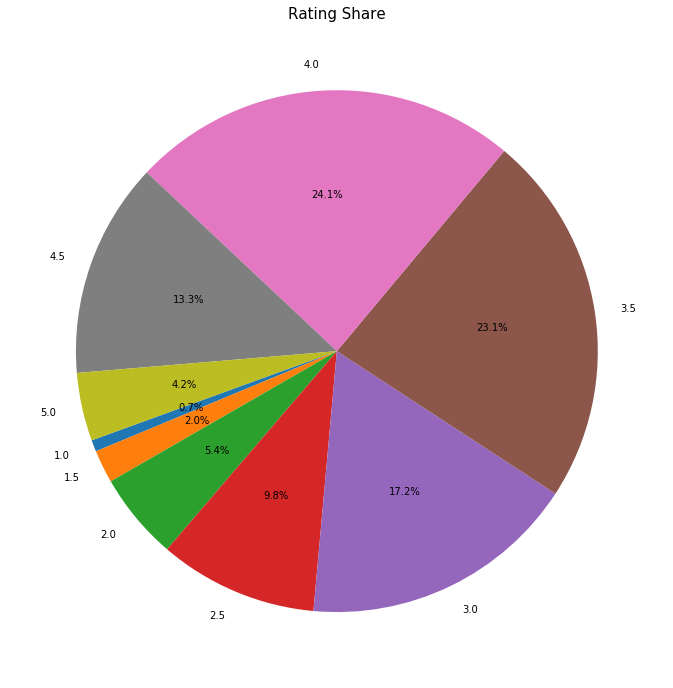

In [17]:
plt.figure(figsize=(12,12))
labels = (np.array(rating_dist.index))
sizes = (np.array((rating_dist / rating_dist.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct= '%1.1f%%', startangle = 200)
plt.title("Rating Share", fontsize=15)
plt.show()

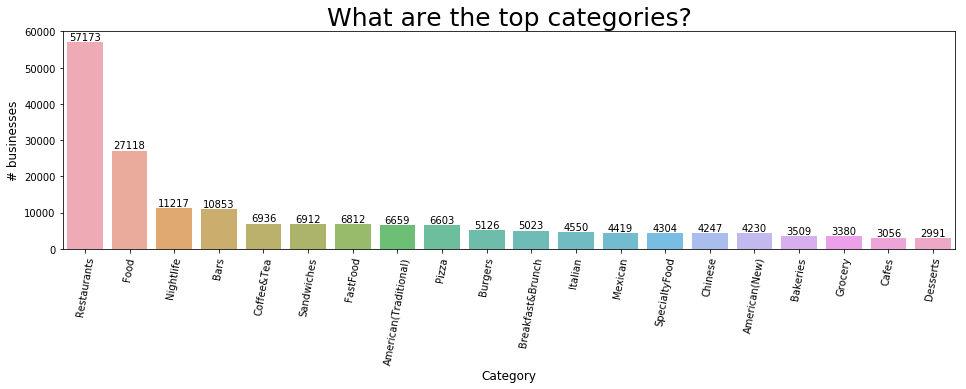

In [18]:
x = cat_all_res_count.iloc[0:20]

plt.figure(figsize=(16,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("What are the top categories?",fontsize=25)
locs, labels = plt.xticks()
plt.setp(labels, rotation=80)
plt.ylabel('# businesses', fontsize=12)
plt.xlabel('Category', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

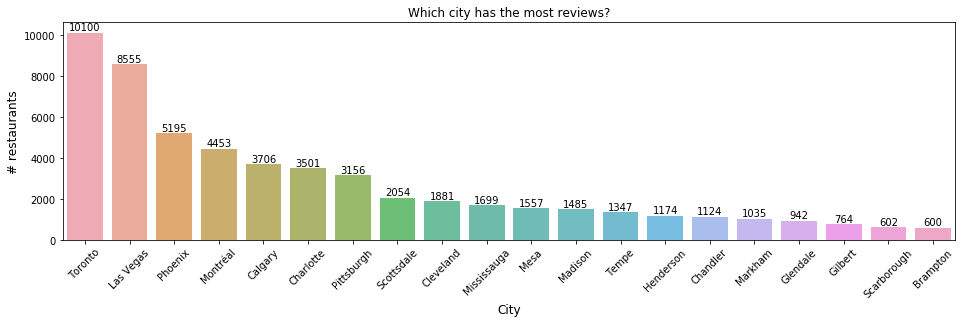

In [19]:
# Location distribution

city_count = restaurants['city'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(16,4))
ax = sns.barplot(city_count[0:20].index, city_count[0:20].values, alpha=0.8)
plt.title("Which city has the most reviews?")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.ylabel('# restaurants', fontsize=12)
plt.xlabel('City', fontsize=12)

rects = ax.patches
labels = city_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

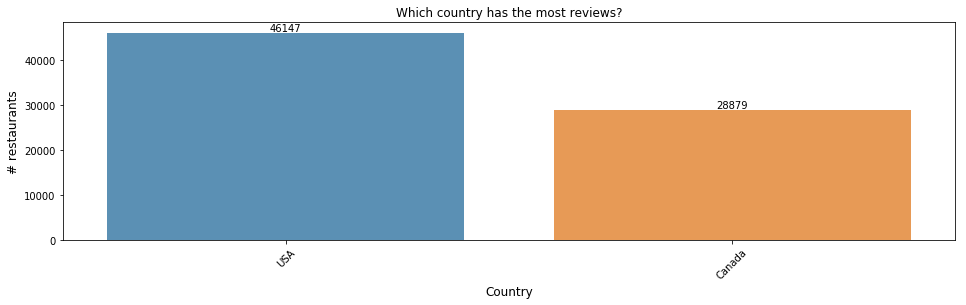

In [20]:
# Country distribution

country_count = restaurants['country'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(16,4))
ax = sns.barplot(country_count.index, country_count.values, alpha=0.8)
plt.title("Which country has the most reviews?")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.ylabel('# restaurants', fontsize=12)
plt.xlabel('Country', fontsize=12)

rects = ax.patches
labels = country_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

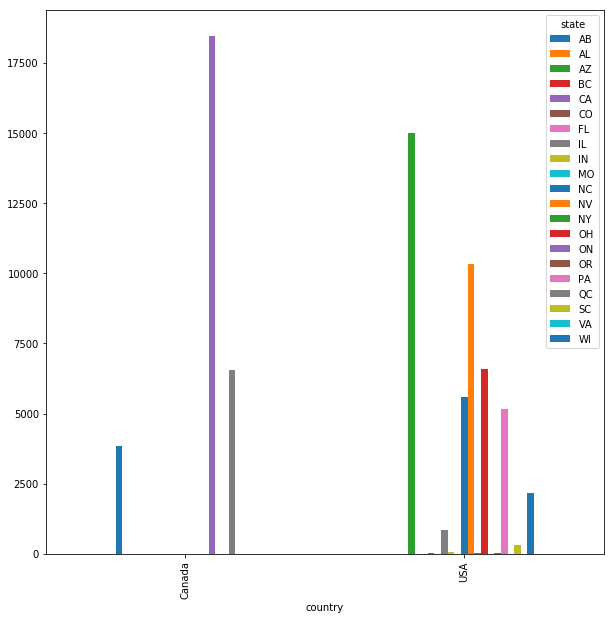

In [21]:
country_state = restaurants.groupby(['country','state'])
country_state = country_state.size().unstack().plot(kind = 'bar',figsize = (10,10))

In [22]:
# Top restaurants by number of reviews

restaurants[['name', 'business_id','review_count', 'city', 'stars']].sort_values(ascending=False, by="review_count")[0:20]

,name,business_id,review_count,city,stars
137635,Mon Ami Gabi,4JNXUYY8wbaaDmk3BPzlWw,7968,Las Vegas,4.0
185167,Bacchanal Buffet,RESDUcs7fIiihp38-d6_6g,7866,Las Vegas,4.0
62723,Wicked Spoon,K7lWdNUhCbcnEvI0NhGewg,6446,Las Vegas,3.5
188309,Gordon Ramsay BurGR,cYwJA2A6I12KNkm2rtXd5g,5472,Las Vegas,4.0
170129,Hash House A Go Go,f4x1YBxkLrZg652xt2KR5g,5382,Las Vegas,4.0
177573,Earl of Sandwich,DkYS3arLOhA8si5uUEmHOw,4981,Las Vegas,4.5
181524,The Buffet,2weQS-RnoOBhb1KsHKyoSQ,4240,Las Vegas,3.5
135008,The Buffet at Bellagio,ujHiaprwCQ5ewziu0Vi9rw,4091,Las Vegas,3.5
180795,Secret Pizza,iCQpiavjjPzJ5_3gPD5Ebg,4078,Las Vegas,4.0
28596,Lotus of Siam,KskYqH1Bi7Z_61pH6Om8pg,3975,Las Vegas,4.0


# 3. Feature Selection

## 3.0 We hypothesize that the following features are important

Review and User-related features

1. Review Count
2. Star Rating
3. Number of users who wrote reviews
4. Maximum number of stars
5. Minimum number of stars
6. Number of reviews voted as 'cool'
7. Number of reviews voted as 'funny'
8. Number of reviews voted as 'useful'
9. Time since first/last reviews
10. Time between first and last reviews
11. Max number of review in a single day


Business Attributes Feature:
    
1. Hours
2. Categories
3. Business Parking
4. Restaurant Reservations
5. Good for Kids
6. Smoking
7. Good for Meal
8. Noise Level
9. Music
10. Ages Allowed
11. Restaurants Good for Groups
12. WiFi
13. Business Accepts Credit Cards
14. Ambience
15. Restaurant Price Range
16. Happy Hour
17. Outdoors Seating

In [23]:
col = restaurants.columns
col

Index(['hours.Friday', 'attributes.RestaurantsAttire',
       'attributes.BikeParking', 'state', 'categories',
       'attributes.BusinessParking', 'attributes.Alcohol',
       'attributes.GoodForDancing', 'attributes.BYOB',
       'attributes.DietaryRestrictions', 'attributes.RestaurantsReservations',
       'attributes.GoodForKids', 'attributes.Smoking', 'hours.Sunday',
       'attributes.BYOBCorkage', 'latitude',
       'attributes.BusinessAcceptsBitcoin', 'attributes.GoodForMeal',
       'attributes.BestNights', 'attributes.NoiseLevel', 'attributes.Corkage',
       'attributes.Music', 'hours.Wednesday', 'attributes.Open24Hours',
       'longitude', 'neighborhood', 'attributes.HairSpecializesIn',
       'hours.Thursday', 'attributes.AgesAllowed',
       'attributes.ByAppointmentOnly', 'business_id',
       'attributes.RestaurantsDelivery', 'attributes.RestaurantsGoodForGroups',
       'postal_code', 'attributes.RestaurantsTableService', 'attributes.WiFi',
       'hours', 'attributes

## 3.1 Merge Restaurants with Users and Reviews

In [24]:
#importing the yelp reviews dataset
datastr=open('yelp_academic_dataset_review.json','r')
datajson=datastr.readlines()
check=[json.loads(x) for x in datajson]
ind=range(0,len(check))
reviews=pd.DataFrame(check,index=ind,columns=check[0].keys())

In [25]:
reviews.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'date', 'text',
       'useful', 'funny', 'cool'],
      dtype='object')

In [26]:
restaurant_reviews = reviews[reviews["business_id"].isin(restaurants["business_id"])]

In [27]:
# User counts, max and min ratings
user_rating_count = restaurant_reviews[['user_id','business_id']].groupby(['business_id']).count()
user_rating_count = user_rating_count.rename(columns = {'business_id':'user_rating_count'})
max_rating_restaurant = restaurant_reviews[['business_id','stars']].groupby(['business_id']).max()
max_rating_restaurant = max_rating_restaurant.rename(columns = {'stars':'max_rating_rest'})
min_rating_restaurant = restaurant_reviews[['business_id','stars']].groupby(['business_id']).min()
min_rating_restaurant = min_rating_restaurant.rename(columns = {'stars':'min_rating_rest'})

In [28]:
# Useful, funny, cool
useful_mean = restaurant_reviews[['business_id','useful']].groupby(['business_id']).mean()
useful_mean = useful_mean.rename(columns = {'business_id':'useful_mean'})
funny_mean = restaurant_reviews[['business_id','funny']].groupby(['business_id']).mean()
funny_mean = funny_mean.rename(columns = {'business_id':'funny_mean'})
cool_mean = restaurant_reviews[['business_id','cool']].groupby(['business_id']).mean()
cool_mean = cool_mean.rename(columns = {'business_id':'cool_mean'})

In [29]:
restaurants = restaurants.merge(max_rating_restaurant, how = 'left', on = 'business_id')
restaurants = restaurants.merge(min_rating_restaurant, how = 'left', on = 'business_id')
restaurants = restaurants.merge(useful_mean, how = 'left', on = 'business_id')
restaurants = restaurants.merge(funny_mean, how = 'left', on = 'business_id')
restaurants = restaurants.merge(cool_mean, how = 'left', on = 'business_id')

In [30]:
restaurants.head()

,hours.Friday,attributes.RestaurantsAttire,attributes.BikeParking,state,categories,attributes.BusinessParking,attributes.Alcohol,attributes.GoodForDancing,attributes.BYOB,attributes.DietaryRestrictions,...,attributes.AcceptsInsurance,attributes,stars,city,country,max_rating_rest,min_rating_rest,useful,funny,cool
0,11:0-21:0,casual,False,AB,"Tours, Breweries, Pizza, Restaurants, Food, Ho...","{'garage': False, 'street': True, 'validated':...",NaN,NaN,NaN,NaN,...,NaN,"{'BikeParking': 'False', 'BusinessAcceptsCredi...",4.0,Calgary,Canada,5,1,0.541667,0.250000,0.208333
1,17:0-23:0,casual,False,NV,"Chicken Wings, Burgers, Caterers, Street Vendo...","{'garage': False, 'street': True, 'validated':...",none,NaN,NaN,NaN,...,NaN,"{'Alcohol': 'none', 'BikeParking': 'False', 'B...",4.5,Henderson,USA,5,4,0.333333,0.000000,0.333333
2,10:0-22:0,casual,True,QC,"Breakfast & Brunch, Restaurants, French, Sandw...","{'garage': False, 'street': False, 'validated'...",beer_and_wine,NaN,NaN,NaN,...,NaN,"{'Alcohol': 'beer_and_wine', 'Ambience': ""{'ro...",4.0,Montréal,Canada,5,1,0.200000,0.000000,0.400000
3,5:30-21:0,NaN,True,AZ,"Coffee & Tea, Food","{'garage': False, 'street': False, 'validated'...",NaN,NaN,NaN,NaN,...,NaN,"{'BikeParking': 'True', 'BusinessAcceptsCredit...",4.0,Phoenix,USA,5,1,0.935484,0.548387,0.629032
4,NaN,NaN,NaN,ON,"Food, Bakeries","{'garage': False, 'street': False, 'validated'...",NaN,NaN,NaN,NaN,...,NaN,"{'BusinessParking': ""{'garage': False, 'street...",4.0,Toronto,Canada,5,3,1.142857,1.142857,1.285714


### 3.1.2 Time-bound features

In [31]:
reviews_date = reviews[['business_id','date']]

In [32]:
reviews_date.date = pd.to_datetime(reviews_date.date)

/usr/local/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [33]:
reviews_date_earliest = reviews_date.groupby('business_id')['date'].min()

In [34]:
reviews_date_earliest = reviews_date_earliest.to_frame()

In [35]:
reviews_date_latest = reviews_date.groupby('business_id')['date'].max()
reviews_date_latest = reviews_date_latest.to_frame()

In [36]:
reviews_date = reviews_date_earliest.merge(reviews_date_latest, how = 'outer', on = 'business_id') 

In [37]:
reviews_date = reviews_date.rename(index=str, columns={"date_x": "earliest_review_date", "date_y": "latest_review_date"})

In [38]:
reviews_date['date_difference'] = reviews_date['latest_review_date'] - reviews_date['earliest_review_date'] 

In [39]:
from datetime import datetime
reviews_date['earliest_till_now'] = datetime.today() - reviews_date['earliest_review_date']
reviews_date['latest_till_now'] = datetime.today() - reviews_date['latest_review_date']

In [40]:
reviews_date['earliest_till_now'] = reviews_date['earliest_till_now'].astype('timedelta64[D]')

In [41]:
reviews_date['latest_till_now'] = reviews_date['latest_till_now'].astype('timedelta64[D]')
reviews_date['date_difference'] = reviews_date['date_difference'].astype('timedelta64[D]')

In [42]:
reviews_date.head()

,earliest_review_date,latest_review_date,date_difference,earliest_till_now,latest_till_now
business_id,,,,,
--1UhMGODdWsrMastO9DZw,2016-06-04,2018-05-06,701.0,910.0,209.0
--6MefnULPED_I942VcFNA,2008-08-07,2018-05-21,3574.0,3768.0,194.0
--7zmmkVg-IMGaXbuVd0SQ,2014-12-30,2018-06-01,1249.0,1432.0,183.0
--8LPVSo5i0Oo61X01sV9A,2014-05-15,2018-02-10,1367.0,1661.0,294.0
--9QQLMTbFzLJ_oT-ON3Xw,2013-05-15,2018-02-17,1739.0,2026.0,287.0


In [43]:
restaurants = restaurants.merge(reviews_date, how = 'left', on = 'business_id')

## 3.2 Ambience

In [44]:
# Understand the ambience
restaurants['attributes.Ambience'].unique()

array([nan,
       "{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': False}",
       "{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': True}",
       "{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': False}",
       "{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': True, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': False}",
       "{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': True}",
       "{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'touristy': False, 'trendy': True, 'upscale': False, 'casual': False}",
       "{'roma

In [45]:
def ambience_extract(row):
    ambience_list = list()
    import ast
    if pd.isnull(row['attributes.Ambience']):
        return None
    else:
        for key, value in ast.literal_eval(row['attributes.Ambience']).items():
            if value == True:
                ambience_list.append(key)
        return ",".join(ambience_list)

In [46]:
restaurants['Ambience'] = restaurants.apply(lambda row: ambience_extract(row),axis=1)

In [47]:
ambience_list = restaurants['Ambience'].tolist()
ambience_list = [x for x in ambience_list if x is not None and x != '']

In [48]:
cat_all_am = ','.join(ambience_list)

In [49]:
cat_all_am = pd.DataFrame(cat_all_am.split(','), columns=['Ambience'])
cat_all_am_count = cat_all_am.Ambience.value_counts().sort_values(ascending = False)
cat_all_am_count

casual      22192
trendy       2428
classy       1061
divey        1057
hipster      1043
intimate      672
romantic      599
upscale       494
touristy      229
Name: Ambience, dtype: int64

We create dummy variables for 'casual', 'trendy' and 'Others'

In [50]:
def ambience_casual(row):
    if row['Ambience'] is not None and row['Ambience'] != '':
        if 'casual' in row['Ambience'].split(','):
            return 1
        else:
            return 0
    else:
        return 0
restaurants['ambience_casual'] = restaurants.apply(lambda row: ambience_casual(row),axis=1)

In [51]:
def ambience_trendy(row):
    if row['Ambience'] is not None and row['Ambience'] != '':
        if 'trendy' in row['Ambience'].split(','):
            return 1
        else:
            return 0
    else:
        return 0
restaurants['ambience_trendy'] = restaurants.apply(lambda row: ambience_trendy(row),axis=1)

In [52]:
ambience_others_list = ['romantic', 'intimate', 'classy', 'hipster', 'touristy', 'upscale', 'divey']
def ambience_others(row):
    if row['Ambience'] is not None and row['Ambience'] != '':
        if (set(ambience_others_list) & set(row['Ambience'].split(','))):
            return 1
        else:
            return 0
    else:
        return 0
restaurants['ambience_others'] = restaurants.apply(lambda row: ambience_others(row),axis=1)

## 3.3 Food categories

Food label will include:
1. American Food
2. Asian Food
3. European Food 
4. Sandwich
5. Burgers
6. Restaurants

In [53]:
american_food = ['American(Traditional)', 'American(New)']
asian_food = ['Chinese','Malaysian','Japanese','AsianFusion','SushiBars','PanAsian','Poke','Indian','Thai',
             'Szechuan','Vietnamese','Korean','Cantonese','Dim Sum','Taiwanese','Filipino','Ramen','Noodles']
european_food = ['Italian','Mediterranean','British','Delicatessen','French','Greek','Polish','Irish','German',
                'Spanish','Portuguese']

In [54]:
def american_food_label(row):
    if bool(set(row['categories'].replace(" ","").split(',')) & set(american_food)):
        return 1
    else:
        return 0
restaurants['american_food'] = restaurants.apply(lambda row: american_food_label(row),axis=1)

In [55]:
def asian_food_label(row):
    if bool(set(row['categories'].replace(" ","").split(',')) & set(asian_food)):
        return 1
    else:
        return 0
restaurants['asian_food'] = restaurants.apply(lambda row: asian_food_label(row),axis=1)

In [56]:
def european_food_label(row):
    if bool(set(row['categories'].replace(" ","").split(',')) & set(european_food)):
        return 1
    else:
        return 0
restaurants['european_food'] = restaurants.apply(lambda row: european_food_label(row),axis=1)

In [57]:
def sandwich_label(row):
    if "Sandwiches" in (row['categories'].replace(" ","").split(',')):
        return 1
    else:
        return 0
restaurants['sandwich'] = restaurants.apply(lambda row: sandwich_label(row),axis=1)

In [58]:
def burger_label(row):
    if "Burgers" in (row['categories'].replace(" ","").split(',')):
        return 1
    else:
        return 0
restaurants['burger'] = restaurants.apply(lambda row: burger_label(row),axis=1)

In [59]:
def restaurant_label(row):
    if "Restaurants" in (row['categories'].replace(" ","").split(',')):
        return 1
    else:
        return 0
restaurants['restaurant'] = restaurants.apply(lambda row: restaurant_label(row),axis=1)

## 3.4 Continuous Features

In [60]:
restaurants['attributes.AgesAllowed'].unique()

array([nan, '18plus', '21plus', 'allages', '19plus'], dtype=object)

In [61]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
restaurants['attributes.AgesAllowed'].fillna('0',inplace=True)
le.fit(['0',"allages", "18plus", "19plus", "21plus"])

LabelEncoder()

In [62]:
le.inverse_transform([0, 2, 1])

array(['0', '19plus', '18plus'], dtype='<U7')

In [63]:
restaurants['attributes.AgesAllowed'] = le.transform(restaurants['attributes.AgesAllowed']) 

## 3.5 Categorical Features

In [64]:
restaurants['attributes.BestNights'].unique()

array([nan,
       "{'monday': False, 'tuesday': True, 'friday': True, 'wednesday': False, 'thursday': False, 'sunday': False, 'saturday': True}",
       "{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': True, 'thursday': False, 'sunday': False, 'saturday': False}",
       "{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': False, 'thursday': False, 'sunday': False, 'saturday': False}",
       "{'monday': True, 'tuesday': False, 'friday': False, 'wednesday': False, 'thursday': False, 'sunday': True, 'saturday': True}",
       "{'monday': True, 'tuesday': False, 'friday': False, 'wednesday': False, 'thursday': True, 'sunday': False, 'saturday': True}",
       "{'monday': False, 'tuesday': False, 'friday': True, 'wednesday': False, 'thursday': True, 'sunday': False, 'saturday': True}",
       "{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': False, 'thursday': False, 'sunday': False, 'saturday': True}",
       "{'monday': False, 'tuesday':

## 3.6 Create Dummy Variables for features

In [65]:
cols_dummy = ['attributes.RestaurantsAttire','attributes.Alcohol',
        'attributes.RestaurantsReservations','attributes.GoodForKids','attributes.Smoking',
        'attributes.NoiseLevel','attributes.Open24Hours',
        'attributes.ByAppointmentOnly','attributes.RestaurantsDelivery',
        'attributes.RestaurantsGoodForGroups','attributes.RestaurantsTableService','attributes.WiFi',
        'attributes.DogsAllowed','attributes.BusinessAcceptsCreditCards',
        'attributes.DriveThru','attributes.Caters','attributes.RestaurantsTakeOut',
        'attributes.WheelchairAccessible','attributes.HasTV','attributes.HappyHour',
        'attributes.CoatCheck','attributes.OutdoorSeating','is_open','attributes.AcceptsInsurance']
        
        
special_col = ['attributes.GoodForMeal', 'attributes.BestNights','attributes.Music',
               'hours', 'attributes.BusinessParking','attributes.RestaurantsAttire']

In [66]:
res_full = pd.get_dummies(data=restaurants, columns = cols_dummy)

In [67]:
res_full.columns.values.tolist()

['hours.Friday',
 'attributes.BikeParking',
 'state',
 'categories',
 'attributes.BusinessParking',
 'attributes.GoodForDancing',
 'attributes.BYOB',
 'attributes.DietaryRestrictions',
 'hours.Sunday',
 'attributes.BYOBCorkage',
 'latitude',
 'attributes.BusinessAcceptsBitcoin',
 'attributes.GoodForMeal',
 'attributes.BestNights',
 'attributes.Corkage',
 'attributes.Music',
 'hours.Wednesday',
 'longitude',
 'neighborhood',
 'attributes.HairSpecializesIn',
 'hours.Thursday',
 'attributes.AgesAllowed',
 'business_id',
 'postal_code',
 'hours',
 'review_count',
 'name',
 'hours.Saturday',
 'attributes.Ambience',
 'attributes.RestaurantsCounterService',
 'address',
 'attributes.RestaurantsPriceRange2',
 'hours.Tuesday',
 'hours.Monday',
 'attributes',
 'stars',
 'city',
 'country',
 'max_rating_rest',
 'min_rating_rest',
 'useful',
 'funny',
 'cool',
 'earliest_review_date',
 'latest_review_date',
 'date_difference',
 'earliest_till_now',
 'latest_till_now',
 'Ambience',
 'ambience_casual

## 3.10 Final Feature Selection

In [202]:
cols_ml = ['review_count',
 'attributes.RestaurantsAttire_casual',
 'attributes.RestaurantsAttire_dressy',
 'attributes.RestaurantsAttire_formal',
 'attributes.Alcohol_full_bar',
 'attributes.RestaurantsReservations_True',
 'attributes.GoodForKids_True',
 'attributes.Smoking_outdoor',
 'attributes.Smoking_yes',
 'attributes.NoiseLevel_very_loud',
 'attributes.Open24Hours_True',
 'attributes.ByAppointmentOnly_True',
 'attributes.RestaurantsGoodForGroups_True',
 'attributes.WiFi_free',
 'attributes.DogsAllowed_True',
 'attributes.BusinessAcceptsCreditCards_True',
 'attributes.DriveThru_True',
 'attributes.Caters_True',
 'attributes.RestaurantsPriceRange2',
 'attributes.RestaurantsTakeOut_True',
 'attributes.HappyHour_True',
 'attributes.CoatCheck_True',
 'attributes.OutdoorSeating_True',
 'ambience_casual',
 'ambience_trendy',
 'ambience_others',
 'attributes.AgesAllowed',
 'max_rating_rest',
 'min_rating_rest',
 'useful','funny','cool',
 'american_food','asian_food','european_food',
 'sandwich','burger','restaurant',
 'date_difference','earliest_till_now','latest_till_now']

# 4. Machine Learning Models

* Logistic Regression
* Random Forest
* Bootstrapping
* XGBoost

## 4.0 Preprocessing

In [294]:
X = res_full[cols_ml]
y = res_full['stars']

In [295]:
X.fillna(0,inplace=True)

Backward elimination using p-value for regression

In [296]:
import statsmodels.api as sm
OLS_model=sm.OLS(y,X)
result=OLS_model.fit()
print(result.summary2())

                              Results: Ordinary least squares
Model:                       OLS                     Adj. R-squared:            0.978      
Dependent Variable:          stars                   AIC:                       117686.6323
Date:                        2018-12-02 00:04        BIC:                       117991.0768
No. Observations:            75026                   Log-Likelihood:            -58810.    
Df Model:                    33                      F-statistic:               1.019e+05  
Df Residuals:                74993                   Prob (F-statistic):        0.00       
R-squared:                   0.978                   Scale:                     0.28091    
-------------------------------------------------------------------------------------------
                                            Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------------------------------
review_count      

Eliminate:
1. attributes.RestaurantsAttire_casual
2. attributes.RestaurantsAttire_formal
3. attributes.Smoking_outdoor
4. attributes.WiFi_free
5. attributes.CoatCheck_True
6. asian_food
7. sandwich

In [297]:
cols_ml = ['review_count',
 'attributes.RestaurantsAttire_dressy',
 'attributes.Alcohol_full_bar',
 'attributes.RestaurantsReservations_True',
 'attributes.GoodForKids_True',
 'attributes.Smoking_yes',
 'attributes.NoiseLevel_very_loud',
 'attributes.Open24Hours_True',
 'attributes.ByAppointmentOnly_True',
 'attributes.RestaurantsGoodForGroups_True',
 'attributes.DogsAllowed_True',
 'attributes.BusinessAcceptsCreditCards_True',
 'attributes.DriveThru_True',
 'attributes.Caters_True',
 'attributes.RestaurantsPriceRange2',
 'attributes.RestaurantsTakeOut_True',
 'attributes.HappyHour_True',
 'attributes.OutdoorSeating_True',
 'ambience_casual',
 'ambience_trendy',
 'ambience_others',
 'attributes.AgesAllowed',
 'max_rating_rest',
 'min_rating_rest',
 'useful','funny','cool',
 'american_food','european_food',
 'burger','restaurant',
 'date_difference','earliest_till_now','latest_till_now']

In [298]:
X = res_full[cols_ml]
y = res_full['stars']
X.fillna(0,inplace=True)

In [299]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3)

## 4.1 Linear Regression

In [300]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(train_X, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [301]:
pred_y  = model.predict(test_X)
pred_y

array([2.56241045, 3.34561357, 3.45596513, ..., 3.36221513, 5.04944048,
       3.60971269])

In [302]:
from sklearn.metrics import mean_squared_error, r2_score

# The coefficients
print('Coefficients: \n', model.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(test_y, pred_y))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(test_y, pred_y))

Coefficients: 
 [ 5.08313671e-04  2.07263330e-01 -7.15907587e-02  5.10080290e-02
 -1.40719562e-02  1.05126886e-01 -2.21707934e-01 -1.36173861e-01
  2.08273291e-01  1.08004527e-02  1.47380844e-01 -4.28071002e-02
 -5.30503615e-01  1.07311454e-01  5.72526448e-03  4.19365087e-02
 -2.77424134e-02  1.34665578e-02  1.81440657e-01  1.49897133e-01
  2.95056549e-01 -5.47178260e-02  6.43742553e-01  4.12895634e-01
 -4.08525721e-02 -9.23599862e-02  1.75789219e-01 -3.68539940e-02
  8.87271554e-02 -1.12345087e-01 -1.41967162e-01  2.13493162e+09
 -2.13493162e+09  2.13493162e+09]
Mean squared error: 0.28
Variance score: 0.59


## 4.1.1 Try to classify the successful restaurant using the result above

In [303]:
res_full['success'] = np.where(restaurants['stars'] >= 3.5,1,0)

In [304]:
X = res_full[cols_ml]
y = res_full['success']
X.fillna(0,inplace=True)
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = 0.3, random_state = 11)

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [305]:
def get_classification(predictions, threshold):
    classes = np.zeros_like(predictions)
    for i in range(len(classes)):
        if predictions[i] > threshold:
            classes[i] = 1
    return classes
get_classification(pred_y, 4)

array([0., 0., 0., ..., 0., 1., 0.])

In [306]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(test_y, get_classification(pred_y,4)).ravel()
print(tn, fp, fn, tp)

6740 1198 12317 2253


In [307]:
accuracy = (tp+tn)/(tp+tn+fp+fn)
print(accuracy)

0.3995468277945619


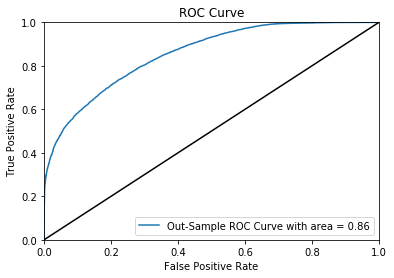

In [308]:
from sklearn.metrics import roc_curve, auc
testing_predictions = model.predict(test_X)
(fpr, tpr, thresholds) = roc_curve(test_y,testing_predictions)

area = auc(fpr,tpr)
plt.clf() #Clear the current figure
plt.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %1.2f"%area)

plt.plot([0, 1], [0, 1], 'k')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## 4.2 Logistic Regression

In [309]:
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression().fit(train_X,train_y)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [310]:
trainset_acc = logr.score(train_X,train_y)
print('logr training set accuracy: {:.3f}'.format(trainset_acc))

logr training set accuracy: 0.789


In [311]:
# Recursive Feature Elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(train_X, train_y)
print(rfe.support_)
print(rfe.ranking_)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

[False  True False False False False  True  True  True False  True  True
  True  True False False False False  True  True  True False  True  True
  True  True  True  True  True  True  True False False False]
[10  1  4  5  7  3  1  1  1  6  1  1  1  1 12  8 11  9  1  1  1  2  1  1
  1  1  1  1  1  1  1 15 13 14]


In [313]:
rfe_rank = rfe.support_

In [314]:
from itertools import compress
cols_log = list(compress(cols_ml, rfe_rank))

In [315]:
X = X[cols_log]

In [316]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.509402
         Iterations 7
                                      Results: Logit
Model:                        Logit                    Pseudo R-squared:         0.215     
Dependent Variable:           success                  AIC:                      76476.7429
Date:                         2018-12-02 00:06         BIC:                      76661.2547
No. Observations:             75026                    Log-Likelihood:           -38218.   
Df Model:                     19                       LL-Null:                  -48690.   
Df Residuals:                 75006                    LLR p-value:              0.0000    
Converged:                    1.0000                   Scale:                    1.0000    
No. Iterations:               7.0000                                                       
-------------------------------------------------------------------------------------------
                 

Eliminate:
1. attributes.Open24Hours_True
2. max_rating_rest

In [317]:
cols_log = ['attributes.RestaurantsAttire_dressy',
 'attributes.NoiseLevel_very_loud',
 'attributes.ByAppointmentOnly_True',
 'attributes.DogsAllowed_True',
 'attributes.BusinessAcceptsCreditCards_True',
 'attributes.DriveThru_True',
 'attributes.Caters_True',
 'ambience_casual',
 'ambience_trendy',
 'ambience_others',
 'min_rating_rest',
 'funny',
 'cool',
 'american_food',
 'european_food',
 'burger',
 'restaurant']

In [318]:
X = X[cols_log]
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.511561
         Iterations 7
                                      Results: Logit
Model:                        Logit                    Pseudo R-squared:         0.212     
Dependent Variable:           success                  AIC:                      76794.7600
Date:                         2018-12-02 00:06         BIC:                      76951.5950
No. Observations:             75026                    Log-Likelihood:           -38380.   
Df Model:                     16                       LL-Null:                  -48690.   
Df Residuals:                 75009                    LLR p-value:              0.0000    
Converged:                    1.0000                   Scale:                    1.0000    
No. Iterations:               7.0000                                                       
-------------------------------------------------------------------------------------------
                 

In [319]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [320]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.75


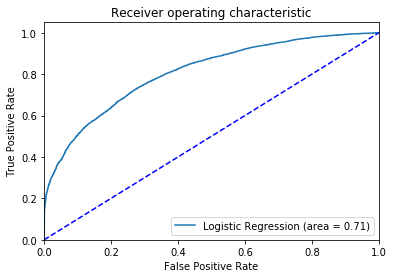

In [322]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## 4.3 Decision Trees

In [323]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

model = tree.DecisionTreeClassifier(max_depth = 5,criterion='entropy')
model.fit(train_X, train_y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [324]:
from sklearn.metrics import confusion_matrix
p_train=model.predict(train_X)
p_test = model.predict(test_X)
print(confusion_matrix(p_train,np.array(train_y)))
print(confusion_matrix(p_test,np.array(test_y)))

[[10594  4196]
 [ 7914 29814]]
[[ 4488  1872]
 [ 3450 12698]]


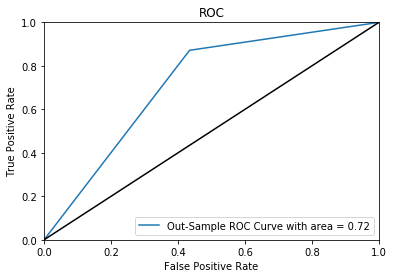

In [325]:
from sklearn.metrics import roc_curve,auc
import pylab as pl
%matplotlib inline
(fpr, tpr, thresholds) = roc_curve(test_y,p_test)
area = auc(fpr,tpr)
pl.clf() #Clear the current figure
pl.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %1.2f"%area)

pl.plot([0, 1], [0, 1], 'k') #This plots the random (equal probability line)
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('ROC')
pl.legend(loc="lower right")
pl.show()

## 4.4 Random Forest

In [326]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
rf.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [327]:
rf.score(test_X,test_y)

0.7747023280611338

In [328]:
rf.feature_importances_

array([9.07596499e-02, 1.87208071e-03, 8.57083390e-03, 9.42934032e-03,
       8.30644301e-03, 1.50281515e-03, 4.12253211e-03, 8.95675064e-05,
       3.10054427e-04, 8.29793235e-03, 2.28516121e-03, 8.13581367e-03,
       1.75781711e-02, 1.03011941e-02, 2.08052168e-02, 7.92370654e-03,
       5.45905447e-03, 1.16898681e-02, 1.25711075e-02, 2.46908537e-03,
       5.96015092e-03, 6.69258625e-04, 1.21092624e-01, 1.19629384e-01,
       7.43725799e-02, 7.93882782e-02, 9.29316460e-02, 7.86203486e-03,
       7.37307384e-03, 8.88019241e-03, 6.31291803e-03, 7.99580568e-02,
       8.35136239e-02, 7.95765505e-02])

In [329]:
import matplotlib.pyplot as plt
%matplotlib inline

importances = rf.feature_importances_
indices = np.argsort(importances)

In [330]:
importances_series = list(zip(cols_log, importances*100))

In [331]:
importances_series = list(zip(*importances_series))
importances_series = pd.Series(importances_series[1], index = importances_series[0])

In [332]:
importances_series = importances_series.sort_values(ascending=False)
importances_series

attributes.RestaurantsAttire_dressy           9.075965
european_food                                 2.080522
cool                                          1.757817
american_food                                 1.030119
attributes.DogsAllowed_True                   0.942934
attributes.ByAppointmentOnly_True             0.857083
attributes.BusinessAcceptsCreditCards_True    0.830644
ambience_others                               0.829793
funny                                         0.813581
burger                                        0.792371
restaurant                                    0.545905
attributes.Caters_True                        0.412253
min_rating_rest                               0.228516
attributes.NoiseLevel_very_loud               0.187208
attributes.DriveThru_True                     0.150282
ambience_trendy                               0.031005
ambience_casual                               0.008957
dtype: float64

Text(0.5, 0, 'Features')

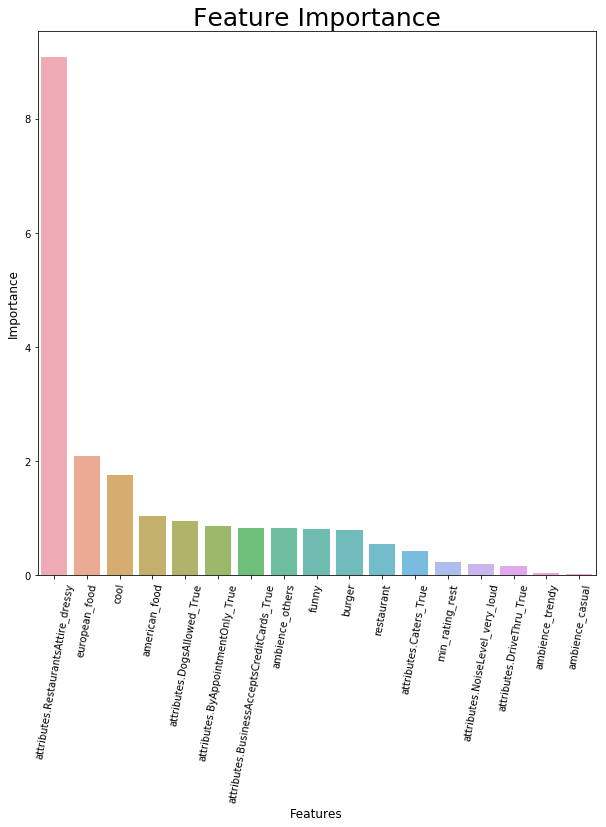

In [334]:
plt.figure(figsize=(10,10))
ax = sns.barplot(importances_series.index, importances_series.values, alpha=0.8)
plt.title("Feature Importance",fontsize=25)
locs, labels = plt.xticks()
plt.setp(labels, rotation=80)
plt.ylabel('Importance', fontsize=12)
plt.xlabel('Features', fontsize=12)

## 4.5 Bootstrapping

In [335]:
from sklearn.ensemble import BaggingClassifier
model=BaggingClassifier()
model.fit(train_X,np.ravel(train_y))

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

In [336]:
model.score(test_X,test_y)

0.7662608850186601

## 4.7 XGBoost

In [ ]:
import sklearn
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.95)

In [ ]:
dtrain = xgb.DMatrix(X_train,label=y_train)
dtest= xgb.DMatrix(X_test,label=y_test)

In [ ]:
train_labels = dtrain.get_label()

params = { 'eta':0.3, 'silent':1, 'objective':'binary:logistic' }
ratio = float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)
params['scale_pos_weight'] = ratio

In [ ]:
import random
for i in range(10):
    mcw=random.randint(1,5)
    gamma=random.randrange(1,5,step=1)/2
    subsample=random.randrange(6,11,step=1)/10
    colbt=random.randrange(6,11,step=1)/10
    maxdepth=random.randint(2,5)

    params[ 'min_child_weight']=mcw
    params['gamma']=gamma
    params['subsample']=subsample
    params[ 'colsample_bytree']=colbt
    params['max_depth']=maxdepth

    num_rounds = 50
    watchlist  = [(dtest,'test'), (dtrain,'train')]
    print(params,'\n')
    bst = xgb.train(params, dtrain, num_rounds, watchlist)
    print('+++++++++++++++++++++++++++++++++++++++++++++++\n')

In [ ]:
import xgboost as xgb
preds = bst.predict(dtest)

In [ ]:
res=[ i>0.5 for i in preds]
res=np.array(res).astype(np.int8)
from sklearn.metrics import roc_auc_score
result=roc_auc_score(np.squeeze(y_test).values,res)
result

### EXPERIMENTAL

**PCA**

In [282]:
X.fillna(0,inplace=True)
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3)

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [283]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_X = sc.fit_transform(train_X)
test_X = sc.transform(test_X)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [284]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 5)

In [285]:
train_X = pca.fit_transform(train_X)
test_X = pca.transform(test_X)
explained_variance = pca.explained_variance_ratio_

In [286]:
explained_variance

array([0.12825621, 0.08190728, 0.06455624, 0.05582148, 0.04684198])